<a href="https://colab.research.google.com/github/chetan015/ganex/blob/main/DCGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Deep Convolutional GAN (DCGAN)**
Main features of DCGAN:
* Use convolutions without any pooling layers
* Use batchnorm in both the generator and the discriminator
* Don't use fully connected hidden layers
* Use ReLU activation in the generator for all layers except for the output, which uses a Tanh activation.
* Use LeakyReLU activation in the discriminator for all layers except for the output, which does not use an activation


In [1]:
import torch
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
torch.manual_seed(0) # Set for testing purposes, please do not change!


def show_tensor_images(image_tensor, num_images=25, size=(1, 28, 28)):
    '''
    Function for visualizing images: Given a tensor of images, number of images, and
    size per image, plots and prints the images in an uniform grid.
    '''
    image_tensor = (image_tensor + 1) / 2
    image_unflat = image_tensor.detach().cpu()
    image_grid = make_grid(image_unflat[:num_images], nrow=5)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

** Generator **
Generator with 4 layers - 3 hidden + 1 output layer

In [2]:
class Generator(nn.Module):
    '''
    Generator Class
    Values:
        z_dim: the dimension of the noise vector, a scalar
        im_chan: the number of channels of the output image, a scalar
              (MNIST is black-and-white, so 1 channel is your default)
        hidden_dim: the inner dimension, a scalar
    '''
    def __init__(self, z_dim=10, im_chan=1, hidden_dim=64):
        super(Generator, self).__init__()
        self.z_dim = z_dim
        # Build the neural network
        self.gen = nn.Sequential(
            self.make_gen_block(z_dim, hidden_dim * 4),
            self.make_gen_block(hidden_dim * 4, hidden_dim * 2, kernel_size=4, stride=1),
            self.make_gen_block(hidden_dim * 2, hidden_dim),
            self.make_gen_block(hidden_dim, im_chan, kernel_size=4, final_layer=True),
        )

    def make_gen_block(self, input_channels, output_channels, kernel_size=3, stride=2, final_layer=False):
        '''
        Function to return a sequence of operations corresponding to a generator block of DCGAN, 
        corresponding to a transposed convolution, a batchnorm (except for in the last layer), and an activation.
        Parameters:
            input_channels: how many channels the input feature representation has
            output_channels: how many channels the output feature representation should have
            kernel_size: the size of each convolutional filter, equivalent to (kernel_size, kernel_size)
            stride: the stride of the convolution
            final_layer: a boolean, true if it is the final layer and false otherwise 
                      (affects activation and batchnorm)
        '''

        #     Steps:
        #       1) Do a transposed convolution using the given parameters.
        #       2) Do a batchnorm, except for the last layer.
        #       3) Follow each batchnorm with a ReLU activation.
        #       4) If its the final layer, use a Tanh activation after the deconvolution.

        # Build the neural block
        if not final_layer:
            return nn.Sequential(
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride),
                nn.BatchNorm2d(output_channels),
                nn.ReLU(inplace=True)
            )
        else: # Final Layer
            return nn.Sequential(
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride),
                nn.Tanh()
            )

    def unsqueeze_noise(self, noise):
        '''
        Function for completing a forward pass of the generator: Given a noise tensor, 
        returns a copy of that noise with width and height = 1 and channels = z_dim.
        Parameters:
            noise: a noise tensor with dimensions (n_samples, z_dim)
        '''
        return noise.view(len(noise), self.z_dim, 1, 1)

    def forward(self, noise):
        '''
        Function for completing a forward pass of the generator: Given a noise tensor, 
        returns generated images.
        Parameters:
            noise: a noise tensor with dimensions (n_samples, z_dim)
        '''
        x = self.unsqueeze_noise(noise)
        return self.gen(x)

def get_noise(n_samples, z_dim, device='cpu'):
    '''
    Function for creating noise vectors: Given the dimensions (n_samples, z_dim)
    creates a tensor of that shape filled with random numbers from the normal distribution.
    Parameters:
        n_samples: the number of samples to generate, a scalar
        z_dim: the dimension of the noise vector, a scalar
        device: the device type
    '''
    return torch.randn(n_samples, z_dim, device=device)

In [3]:

'''
Test make_gen_block() function
'''
gen = Generator()
num_test = 100

# Test the hidden block
test_hidden_noise = get_noise(num_test, gen.z_dim)
test_hidden_block = gen.make_gen_block(10, 20, kernel_size=4, stride=1)
test_uns_noise = gen.unsqueeze_noise(test_hidden_noise)
hidden_output = test_hidden_block(test_uns_noise)

# Check that it works with other strides
test_hidden_block_stride = gen.make_gen_block(20, 20, kernel_size=4, stride=2)

test_final_noise = get_noise(num_test, gen.z_dim) * 20
test_final_block = gen.make_gen_block(10, 20, final_layer=True)
test_final_uns_noise = gen.unsqueeze_noise(test_final_noise)
final_output = test_final_block(test_final_uns_noise)

# Test the whole thing:
test_gen_noise = get_noise(num_test, gen.z_dim)
test_uns_gen_noise = gen.unsqueeze_noise(test_gen_noise)
gen_output = gen(test_uns_gen_noise)

In [4]:
try:
    assert tuple(hidden_output.shape) == (num_test, 20, 4, 4)
    assert hidden_output.max() > 1
    assert hidden_output.min() == 0
    assert hidden_output.std() > 0.2
    assert hidden_output.std() < 1
    assert hidden_output.std() > 0.5

    assert tuple(test_hidden_block_stride(hidden_output).shape) == (num_test, 20, 10, 10)

    assert final_output.max().item() == 1
    assert final_output.min().item() == -1

    assert tuple(gen_output.shape) == (num_test, 1, 28, 28)
    assert gen_output.std() > 0.5
    assert gen_output.std() < 0.8
    print("Success!")
except: 
    print("Some of asserts have fail")

Success!


In [5]:
class Discriminator(nn.Module):
    '''
    Discriminator Class
    Values:
        im_chan: the number of channels of the output image, a scalar
              (MNIST is black-and-white, so 1 channel is your default)
    hidden_dim: the inner dimension, a scalar
    '''
    def __init__(self, im_chan=1, hidden_dim=16):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            self.make_disc_block(im_chan, hidden_dim),
            self.make_disc_block(hidden_dim, hidden_dim * 2),
            self.make_disc_block(hidden_dim * 2, 1, final_layer=True),
        )

    def make_disc_block(self, input_channels, output_channels, kernel_size=4, stride=2, final_layer=False):
        '''
        Function to return a sequence of operations corresponding to a discriminator block of DCGAN, 
        corresponding to a convolution, a batchnorm (except for in the last layer), and an activation.
        Parameters:
            input_channels: how many channels the input feature representation has
            output_channels: how many channels the output feature representation should have
            kernel_size: the size of each convolutional filter, equivalent to (kernel_size, kernel_size)
            stride: the stride of the convolution
            final_layer: a boolean, true if it is the final layer and false otherwise 
                      (affects activation and batchnorm)
        '''
        #     Steps:
        #       1) Add a convolutional layer using the given parameters.
        #       2) Do a batchnorm, except for the last layer.
        #       3) Follow each batchnorm with a LeakyReLU activation with slope 0.2.
        
        # Build the neural block
        if not final_layer:
            return nn.Sequential(
                nn.Conv2d(input_channels, output_channels, kernel_size, stride),
                nn.BatchNorm2d(output_channels),
                nn.LeakyReLU(0.2, inplace=True)
            )
        else: # Final Layer
            return nn.Sequential(
                nn.Conv2d(input_channels, output_channels, kernel_size, stride)
            )

    '''
    Function for completing a forward pass of the discriminator: Given an image tensor, 
    returns a 1-dimension tensor representing fake/real.
    Parameters:
        image: a flattened image tensor with dimension (im_dim)
    '''
    def forward(self, image):
        disc_pred = self.disc(image)
        return disc_pred.view(len(disc_pred), -1)

In [6]:
'''
Test your make_disc_block() function
'''
num_test = 100

gen = Generator()
disc = Discriminator()
test_images = gen(get_noise(num_test, gen.z_dim))

# Test the hidden block
test_hidden_block = disc.make_disc_block(1, 5, kernel_size=6, stride=3)
hidden_output = test_hidden_block(test_images)

# Test the final block
test_final_block = disc.make_disc_block(1, 10, kernel_size=2, stride=5, final_layer=True)
final_output = test_final_block(test_images)

# Test the whole thing:
disc_output = disc(test_images)


In [7]:
try:
    # Test the hidden block
    assert tuple(hidden_output.shape) == (num_test, 5, 8, 8)
    # Because of the LeakyReLU slope
    assert -hidden_output.min() / hidden_output.max() > 0.15
    assert -hidden_output.min() / hidden_output.max() < 0.25
    assert hidden_output.std() > 0.5
    assert hidden_output.std() < 1

    # Test the final block

    assert tuple(final_output.shape) == (num_test, 10, 6, 6)
    assert final_output.max() > 1.0
    assert final_output.min() < -1.0
    assert final_output.std() > 0.3
    assert final_output.std() < 0.6

    # Test the whole thing:

    assert tuple(disc_output.shape) == (num_test, 1)
    assert disc_output.std() > 0.25
    assert disc_output.std() < 0.5
    print("Success!")
except:
    print("Some of asserts have fail")

Success!


**Training**
Parameters:
* criterion: the loss function
* n_epochs: the number of times you iterate through the entire dataset when training
* z_dim: the dimension of the noise vector
* display_step: how often to display/visualize the images
* batch_size: the number of images per forward/backward pass
* lr: the learning rate
* beta_1, beta_2: the momentum term
* device: the device type


In [10]:
criterion = nn.BCEWithLogitsLoss()
z_dim = 64
display_step = 500
batch_size = 128
lr = 0.0002

beta_1 = 0.5
beta_2 = 0.999
device = 'cuda'

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])
dataloader = DataLoader(MNIST('.', download = False, transform = transform),batch_size=batch_size, shuffle = True)

In [11]:
gen = Generator(z_dim).to(device)
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr, betas=(beta_1, beta_2))
disc = Discriminator().to(device)
disc_opt = torch.optim.Adam(disc.parameters(), lr=lr, betas=(beta_1, beta_2))

# You initialize the weights to the normal distribution
# with mean 0 and standard deviation 0.02
def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)
gen = gen.apply(weights_init)
disc = disc.apply(weights_init)

Step 500: Generator loss: 0.8490946124792097, discriminator loss: 0.5495291319787503


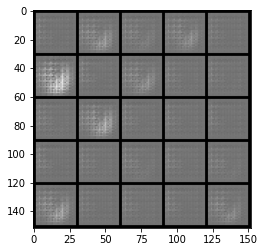

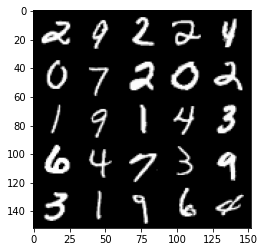

Step 1000: Generator loss: 1.4977394160628317, discriminator loss: 0.3693541842401027


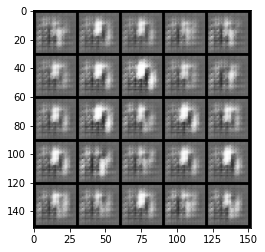

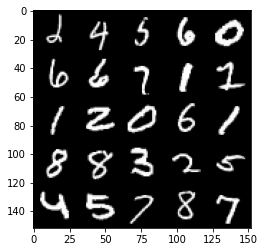

Step 1500: Generator loss: 1.4081561582237476, discriminator loss: 0.4470805087983609


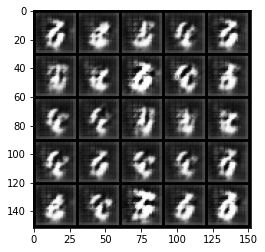

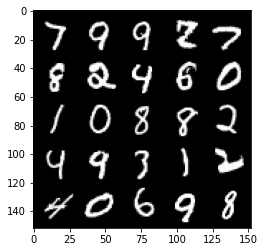

Step 2000: Generator loss: 1.0851654062569154, discriminator loss: 0.5335609327554708


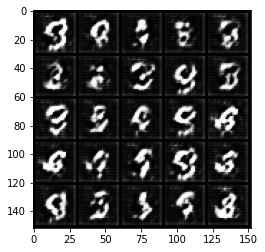

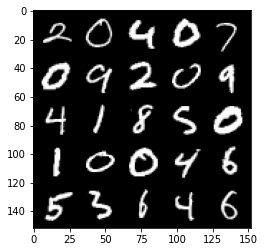

Step 2500: Generator loss: 0.9385836420655246, discriminator loss: 0.5780171020627021


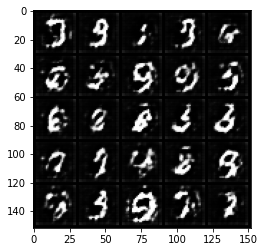

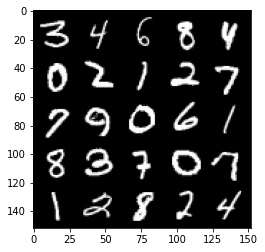

Step 3000: Generator loss: 0.9008629571795459, discriminator loss: 0.5937642000913617


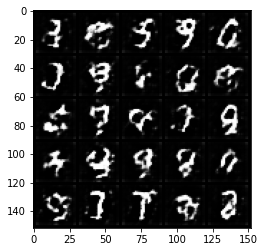

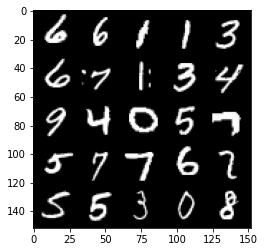

Step 3500: Generator loss: 0.8253694035410881, discriminator loss: 0.6395001860857015


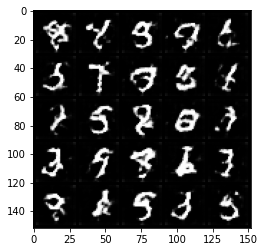

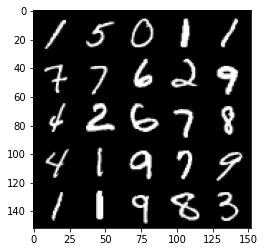

Step 4000: Generator loss: 0.7875969491600995, discriminator loss: 0.6525073155164723


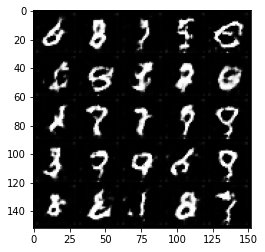

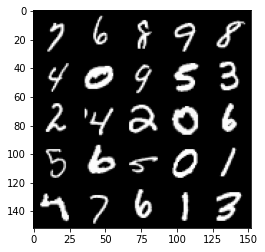

Step 4500: Generator loss: 0.7832711344957354, discriminator loss: 0.6589780833721155


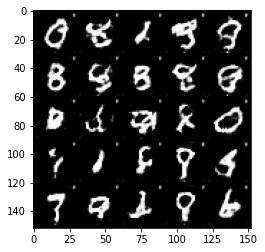

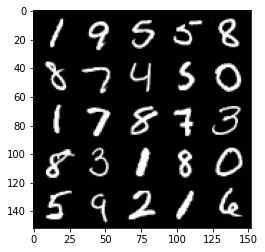

Step 5000: Generator loss: 0.7546578016877176, discriminator loss: 0.6738710186481471


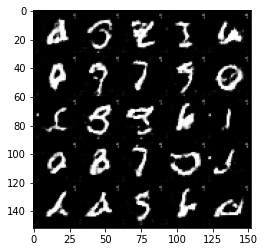

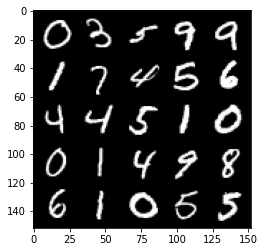

Step 5500: Generator loss: 0.747885233938694, discriminator loss: 0.6788290388584141


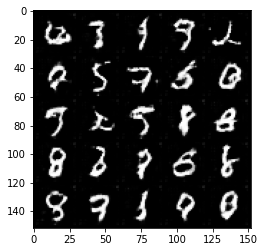

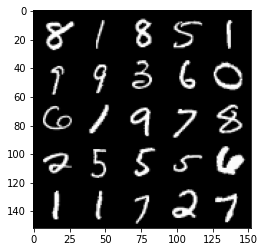

Step 6000: Generator loss: 0.7446608189940459, discriminator loss: 0.6809057295322415


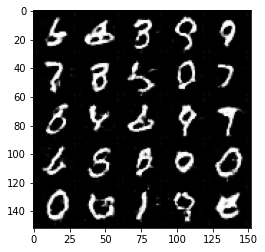

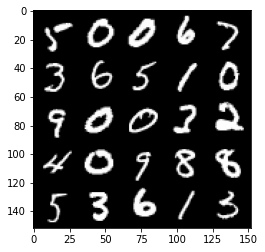

Step 6500: Generator loss: 0.7364754095673559, discriminator loss: 0.6832039632797234


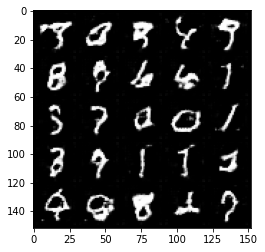

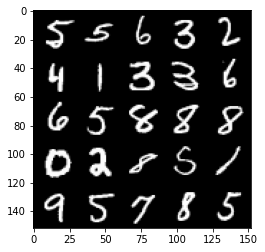

Step 7000: Generator loss: 0.7431981824040415, discriminator loss: 0.6838153136968613


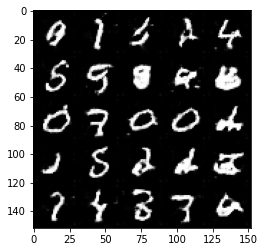

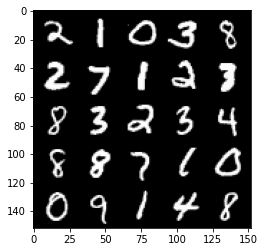

In [ ]:
n_epochs = 50
cur_step = 0
mean_generator_loss = 0
mean_discriminator_loss = 0
for epoch in range(n_epochs):
  # Dataloader returns the batches
  for real, _ in tqdm(dataloader):
    cur_batch_size = len(real)
    real = real.to(device)

    ## Update discriminator 
    disc_opt.zero_grad()
    fake_noise = get_noise(cur_batch_size, z_dim, device=device)
    fake = gen(fake_noise)
    disc_fake_pred = disc(fake.detach())
    disc_fake_loss = criterion(disc_fake_pred, torch.zeros_like(disc_fake_pred))
    disc_real_pred = disc(real)
    disc_real_loss = criterion(disc_real_pred, torch.ones_like(disc_real_pred))
    disc_loss = (disc_fake_loss + disc_real_loss)/2

    # Keep track of the average discriminator loss
    mean_discriminator_loss += disc_loss.item() / display_step
    # Update gradients
    disc_loss.backward(retain_graph = True)
    # Update optimizer
    disc_opt.step()

    ## Update generator
    gen_opt.zero_grad()
    fake_noise_2 = get_noise(cur_batch_size, z_dim, device=device)
    fake_2 = gen(fake_noise_2)
    disc_fake_pred = disc(fake_2)
    gen_loss = criterion(disc_fake_pred, torch.ones_like(disc_fake_pred))
    gen_loss.backward()
    gen_opt.step()

    # Keep track of average generator loss
    mean_generator_loss += gen_loss.item()/display_step
    
    ## Visualization code
    if cur_step % display_step == 0 and cur_step>0:
      print(f"Step {cur_step}: Generator loss: {mean_generator_loss}, discriminator loss: {mean_discriminator_loss}")
      show_tensor_images(fake)
      show_tensor_images(real)
      mean_generator_loss = 0
      mean_discriminator_loss = 0
    cur_step += 1